In [29]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

from Environment.env_v8 import *
from Functions.visualization_functions import *

In [30]:
# Configuration of the network
with open('./Config/network_config_v1.json') as file:
    network_config = file.read()

EP_LENGTH = 100

In [37]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="PPO",
        stockout_cost=config["stockout_cost"],
        order_cost=config["order_cost"],
        item_cost=config["item_cost"],
        stock_cost=config["stock_cost"],
        item_prize=config["item_prize"],
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
    )

    env = Monitor(env)

    return env

env = make_env("./Config/env_config_v0.json")
check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [32]:
log_path = os.path.join('Training', 'Logs', 'PPO')
model_path = os.path.join('Training', 'Models', 'PPO')

In [33]:
# Load the study from training
with open("./Training/PPO_optuna_study_2024-12-01_19_02.pkl", "rb") as f:
    study = pickle.load(f)

print("Best parameters from loaded study:", study.best_params)

Best parameters from loaded study: {'learning_rate': 2.2189718765848422e-05, 'gamma': 0.9256844451434815, 'ent_coef': 0.0003461669566825764, 'vf_coef': 0.5398884275649528}


In [40]:
# vec_env = DummyVecEnv([lambda: make_env("./Config/env_config_v0.json")])
# vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

num_envs = 4  # Adjust based on your system
env_config_path = "./Config/env_config_v0.json"

vec_env = SubprocVecEnv([lambda: make_env(env_config_path) for _ in range(num_envs)])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

best_params = study.best_params

# model = PPO(
#     "MultiInputPolicy", 
#     vec_env,
#     verbose=0,
#     learning_rate=best_params["learning_rate"],
#     gamma=best_params["gamma"],
#     clip_range=0.2,
#     ent_coef=best_params["ent_coef"],
#     vf_coef=best_params["vf_coef"],          
#     n_steps=2048,
#     batch_size=64,
#     tensorboard_log=log_path,
#     )

model = PPO(
    "MultiInputPolicy", 
    vec_env,
    verbose=0,
    learning_rate=0.0003 ,
    gamma=0.99,
    clip_range=0.15,
    ent_coef=0.01,
    vf_coef=0.5,
    n_steps=2048,
    batch_size=64,
    tensorboard_log=log_path,
    device="cuda",
    )

In [41]:
model.learn(total_timesteps=500_000)

In [ ]:
model.save(os.path.join(model_path, "PPO_SS_Mngmt_v0"))

In [52]:
evaluate_policy(model, vec_env, n_eval_episodes=1, render=False, return_episode_rewards=True)

([-761.98], [100])

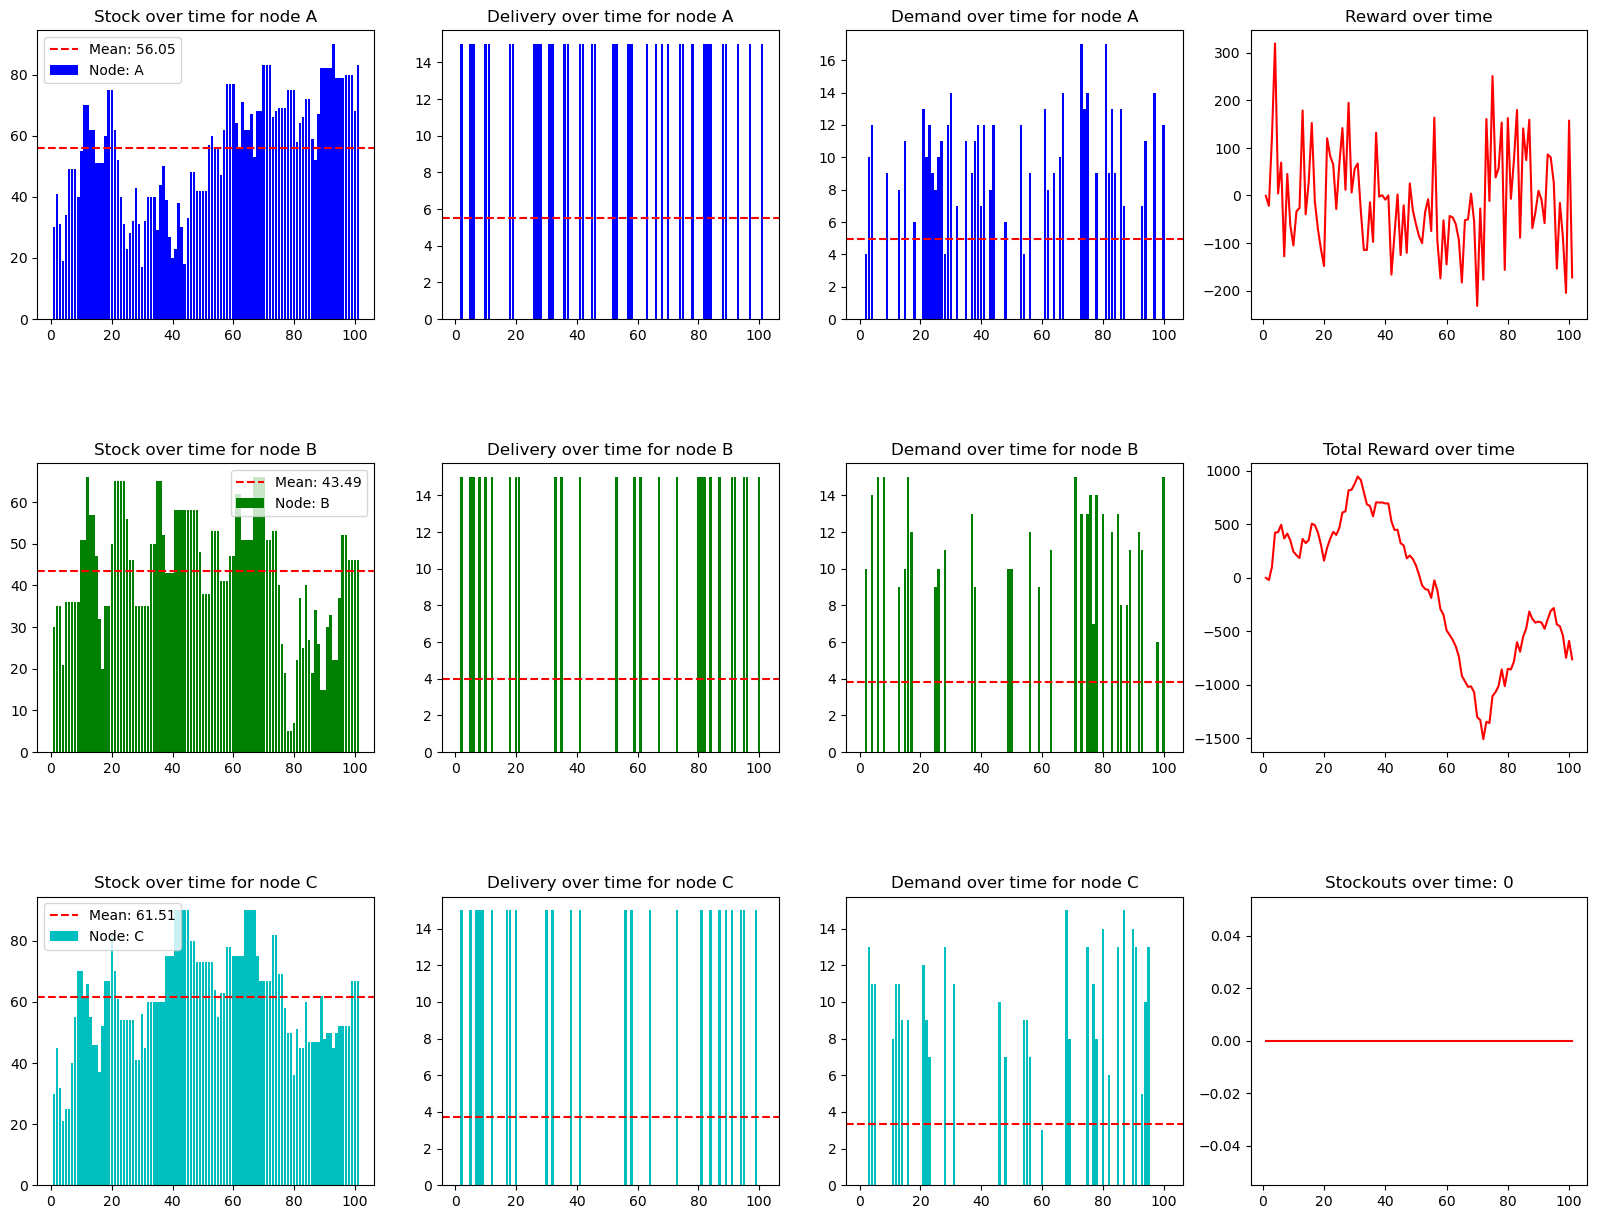

In [53]:
file = './Data/2024-12-01_last_environment_data_PPO.csv'
df = pd.read_csv(file)

plot_data(df)

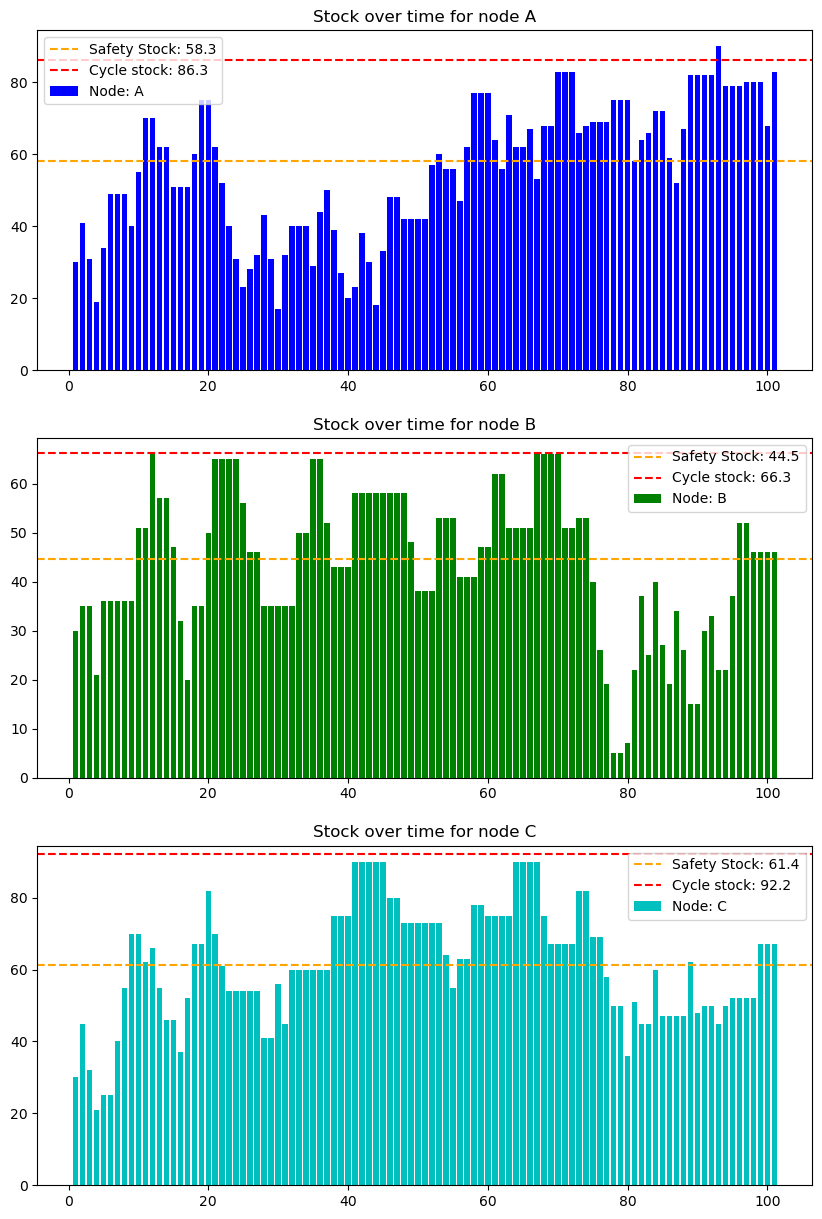

In [54]:
plot_safety_stock(df)